In [29]:
import jetnet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/jet_plots/Oct11"
_ = os.system(f"mkdir -p {plot_dir}")


In [7]:
jetnet.datasets.JetNet.all_particle_features


['etarel', 'phirel', 'ptrel', 'mask']

In [4]:
truth_jets_pf, _ = jetnet.datasets.JetNet.getData(
    "g",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[1.0, 0, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)


In [72]:
efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
np.save("efps", efps)


In [27]:
true_efps = np.load("efps.npy")
true_pnet_activations = np.load("pnet_activations.npy")


In [9]:
from typing import OrderedDict
from coffea.lookup_tools.dense_lookup import dense_lookup

mass = jetnet.utils.jet_features(truth_jets_pf[:, :, :3])["mass"]

np.random.seed(4)

bins = np.linspace(0, np.max(mass), 26)
true_mass_hist = np.histogram(mass, bins)[0]

smeared_hist = np.histogram(mass * np.random.normal(1, 0.25, size=mass.shape), bins)[0]
shifted_hist = np.histogram(mass * np.random.normal(1.1, 0.05, size=mass.shape), bins)[0]

smeared_lookup = dense_lookup(smeared_hist / true_mass_hist, bins)
shifted_lookup = dense_lookup(shifted_hist / true_mass_hist, bins)

smeared_weights = smeared_lookup(mass)
smeared_weights /= np.sum(smeared_weights)

shifted_weights = shifted_lookup(mass)
shifted_weights /= np.sum(shifted_weights)

tailcut_weights = (mass < 0.17).astype(float)
tailcut_weights /= np.sum(tailcut_weights)

dists = OrderedDict(
    [
        ("truth", (np.ones(truth_jets_pf.shape[0]) / truth_jets_pf.shape[0], "Truth")),
        ("smeared", (smeared_weights, "Smeared")),
        ("shifted", (shifted_weights, "Shifted")),
        ("tailcut", (tailcut_weights, "Removing Tail")),
    ]
)


In [24]:
np.random.seed(4)

pf_dists = OrderedDict()

pf_dists["all_smeared"] = (
    truth_jets_pf * np.random.normal(1, 0.25, size=truth_jets_pf.shape),
    "Particle Features Smeared",
)
pf_dists["eta_smeared"] = (
    np.concatenate(
        (
            truth_jets_pf[..., 0:1] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 0:1].shape),
            truth_jets_pf[..., 1:],
        ),
        axis=-1,
    ),
    r"Particle $\eta^{rel}$ Smeared",
)
pf_dists["pt_smeared"] = (
    np.concatenate(
        (
            truth_jets_pf[..., :2],
            truth_jets_pf[..., 2:3] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 2:3].shape),
        ),
        axis=-1,
    ),
    r"Particle $p_T^{rel}$ Smeared",
)
pf_dists["pt_shifted"] = (
    np.concatenate(
        (
            truth_jets_pf[..., :2],
            truth_jets_pf[..., 2:3]
            * np.random.normal(0.9, 0.1, size=truth_jets_pf[..., 2:3].shape),
        ),
        axis=-1,
    ),
    r"Particle $p_T^{rel}$ Shifted",
)


masses = {key: jetnet.utils.jet_features(jets)["mass"] for key, (jets, _) in pf_dists.items()}


In [31]:
with open("pf_dists.pkl", "wb") as f:
    pickle.dump(pf_dists, f)

In [28]:
efps = {
    key: jetnet.utils.efps(jets, efpset_args=[("d<=", 4)]) for key, (jets, _) in pf_dists.items()
}


In [30]:
with open("efps_dict.pkl", "wb") as f:
    pickle.dump(efps, f)

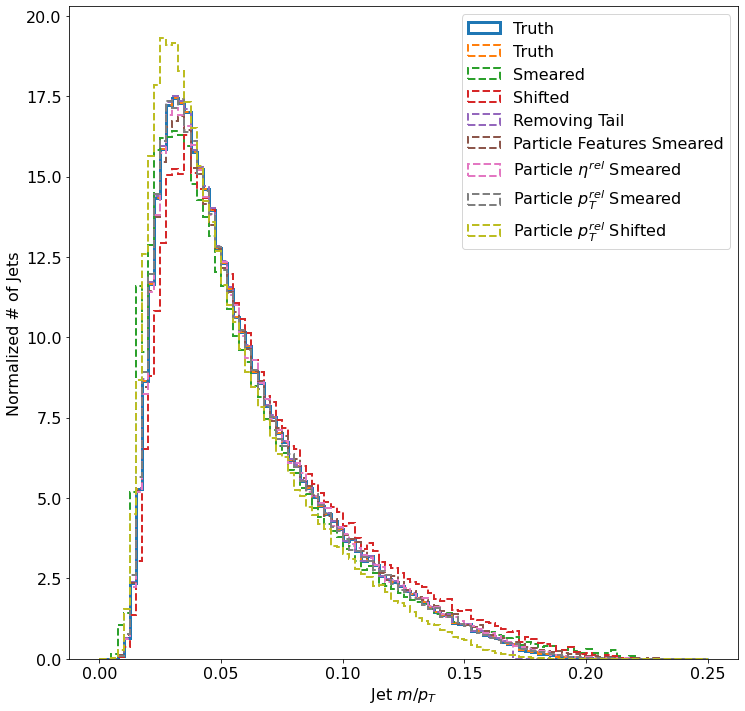

In [26]:
plt.figure(figsize=(12, 12))

bins = np.linspace(0, 0.25, 101)

_ = plt.hist(mass, bins, histtype="step", label="Truth", linewidth=3, density=True)
for weights, label in dists.values():
    _ = plt.hist(
        mass,
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        masses[key],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists.pdf", bbox_inches="tight")


In [16]:
num_samples = 50_000
sample_efps = OrderedDict()
sample_acts = OrderedDict()

true_inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
true_efps = efps[true_inds]
true_acts = pnet_activations[true_inds]

for key, (weights, _) in dists.items():
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples, p=weights)
    sample_efps[key] = efps[inds]
    sample_acts[key] = pnet_activations[inds]


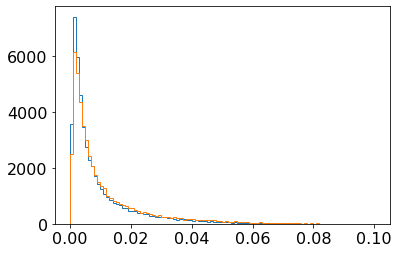

In [43]:
_ = plt.hist(true_efps[:, 2], np.linspace(0, 0.1, 101), histtype="step")
_ = plt.hist(sample_efps["shifted"][:, 2], np.linspace(0, 0.1, 101), histtype="step")


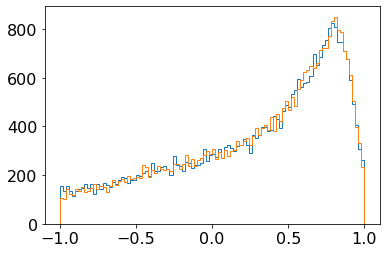

In [77]:
_ = plt.hist(true_acts[:, 0], np.linspace(-1, 1, 101), histtype="step")
_ = plt.hist(sample_acts["tailcut"][:, 0], np.linspace(-1, 1, 101), histtype="step")


In [142]:
num_batches = 5

batch_sizes = {
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000],
    "fgd": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
}

metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD Poly Deg=4 Quadratic Unbiased Est.",
            ),
        ),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
    ]
)


In [140]:
if "measurements_efps" not in locals():
    measurements_efps = OrderedDict()

for dkey in dists:
    print(dkey)
    if dkey not in measurements_efps:
        measurements_efps[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements_efps[dkey]:  # not mkey.startswith("mmdu"): #
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_efps,
                sample_efps[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements_efps[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


mmdu10: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


smeared


mmdu10: 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


shifted


mmdu10: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


tailcut


mmdu10: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


In [136]:
if "measurements_acts" not in locals():
    measurements_acts = OrderedDict()

for dkey in dists:
    print(dkey)
    if dkey not in measurements_acts:
        measurements_acts[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (
            mkey in measurements_acts[dkey]
        ):  # and not (mkey == "mmdup4"):  # not mkey.startswith("mmdu"): #
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_acts,
                sample_acts[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args,
                normalise=False
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements_acts[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


mmdu: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


smeared


mmdu: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


shifted


mmdu: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


tailcut


mmdu: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


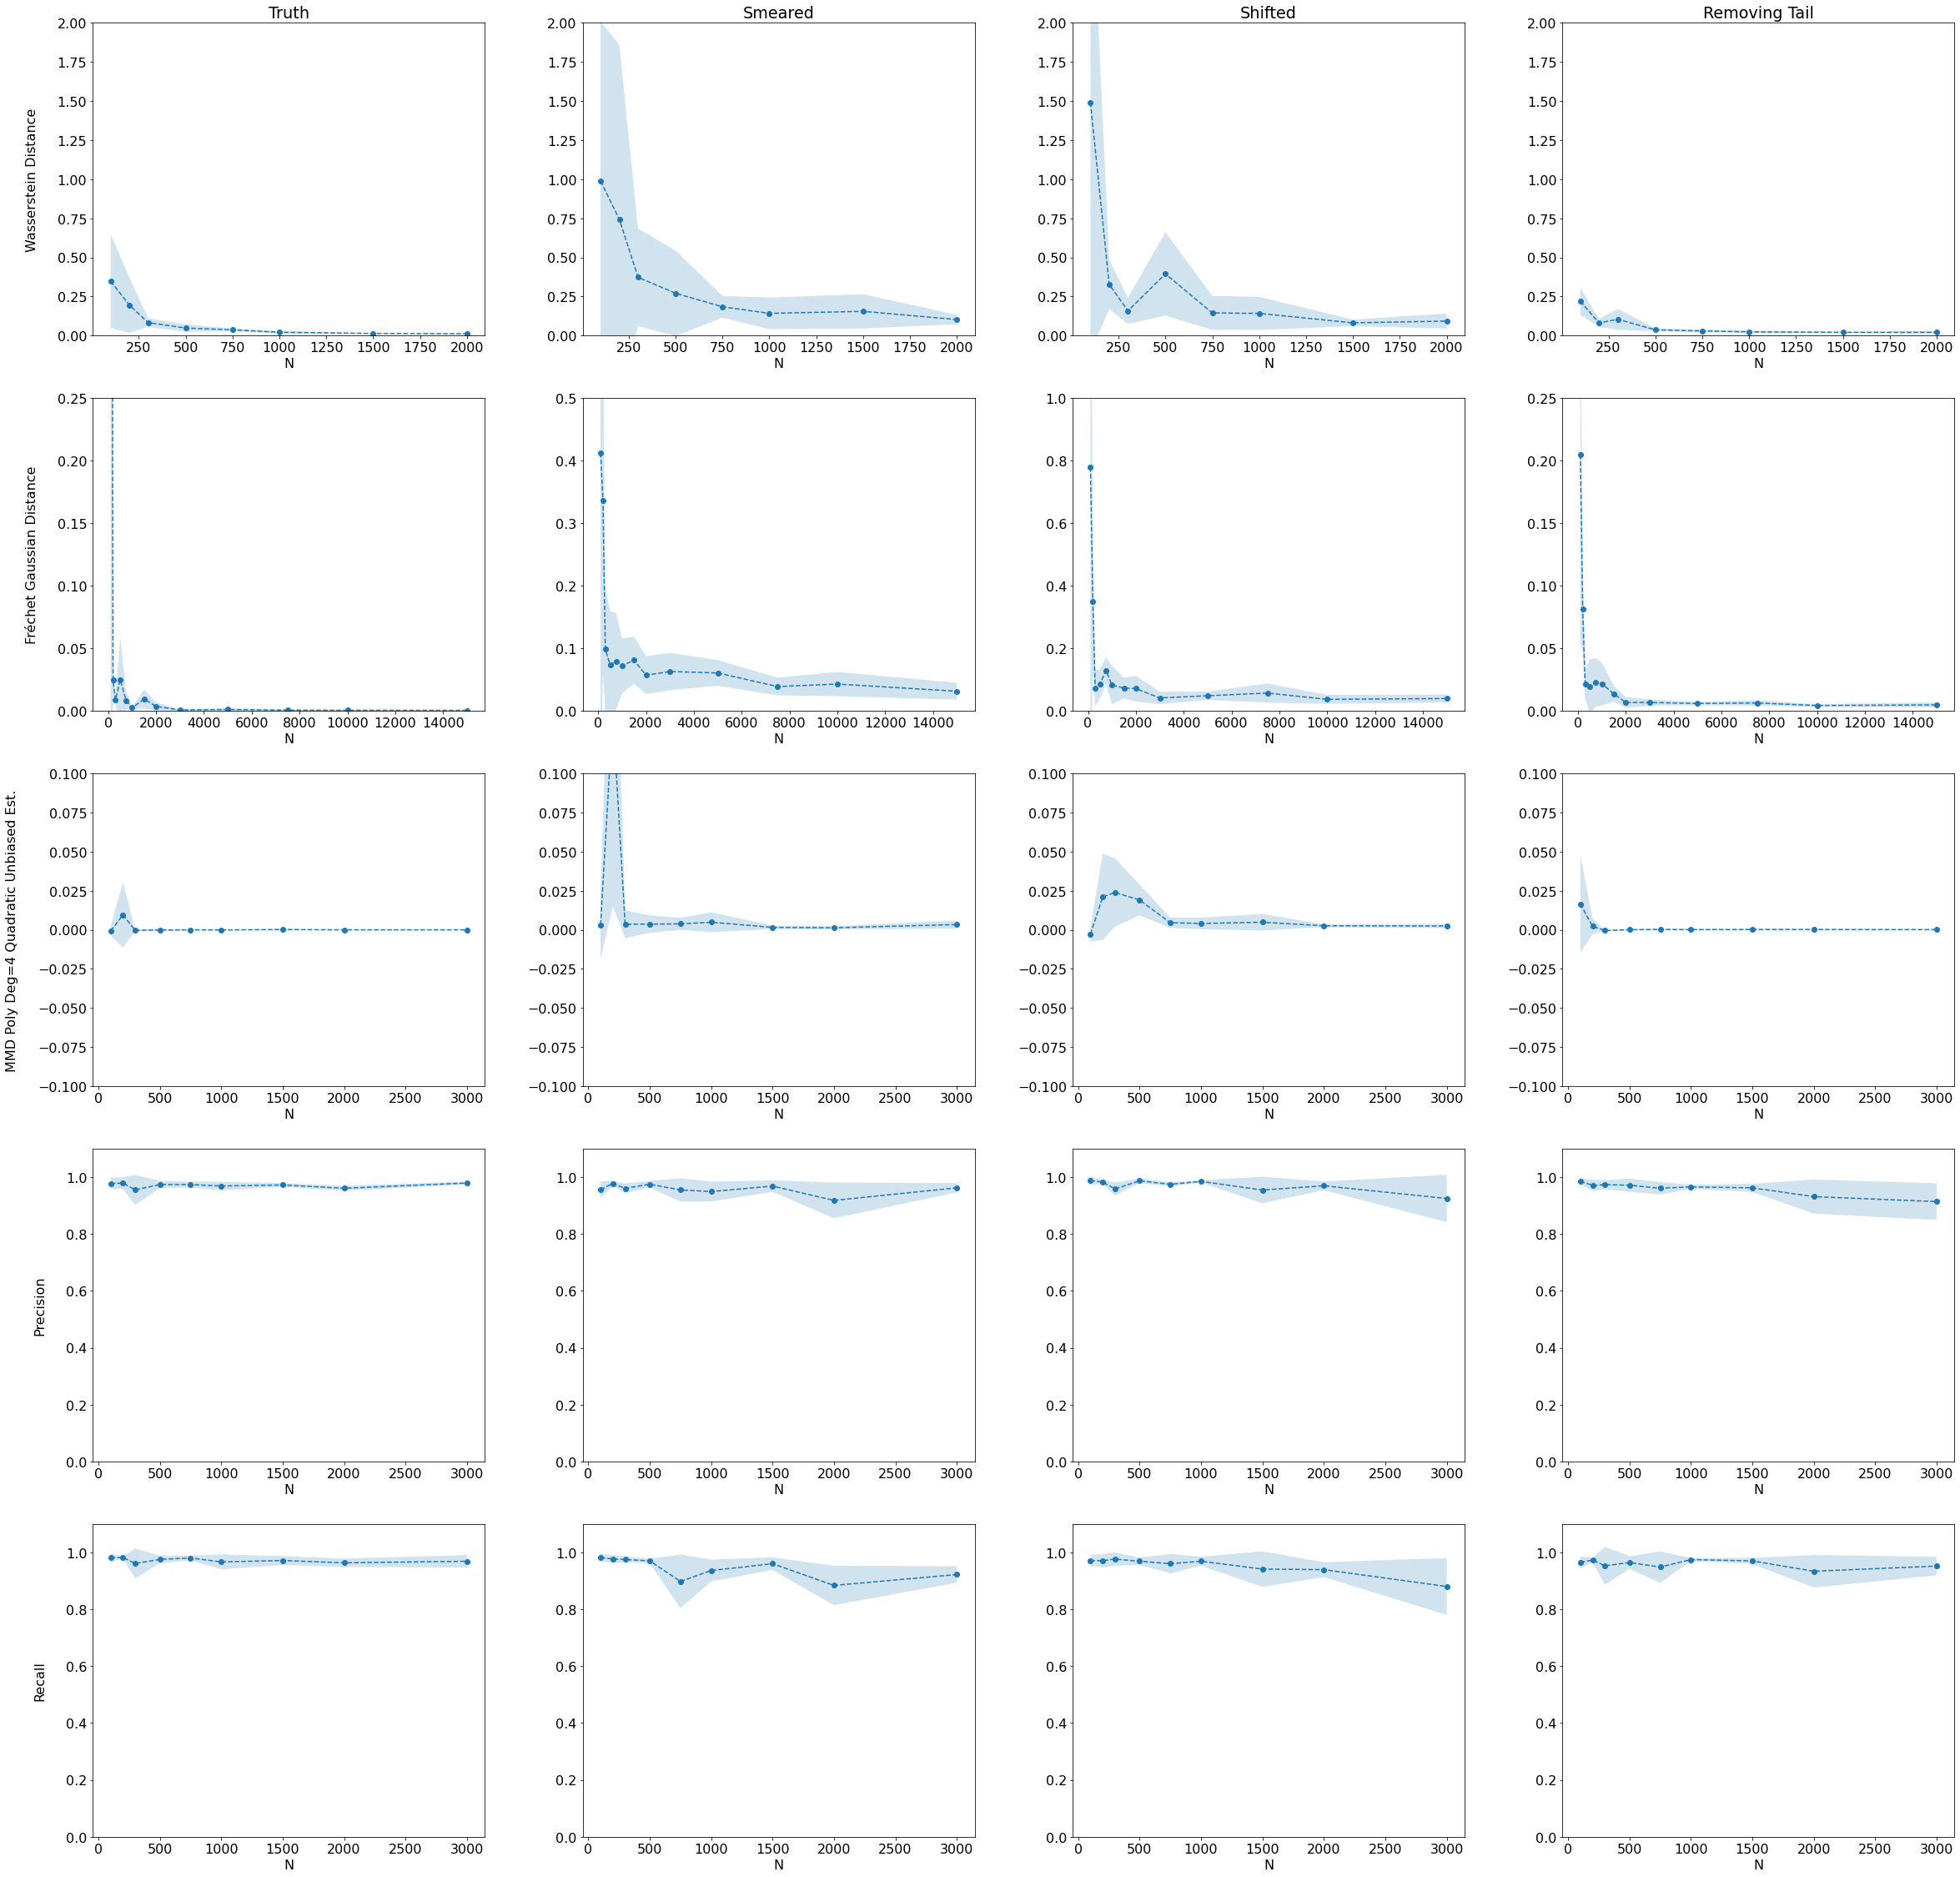

In [144]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 2], [0, 2], [0, 2], [0, 2])),
        ("fgd", ([0, 0.25], [0, 0.5], [0, 1], [0, 0.25])),
        ("mmdup4", ([-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists),
    figsize=(len(dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey == "prdc" or mkey == "dc" or mkey == "pr":
        continue

    axes[i][0].annotate(
        label,
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, (dkey, (_, label)) in enumerate(dists.items()):
        if i == 0:
            axes[i][j].set_title(label)

        means = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 0])[
            : len(batch_sizes[mkey])
        ]
        stds = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 1])[
            : len(batch_sizes[mkey])
        ]

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[mkey][j])
        axes[i][j].set_xlabel("N")

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, dkey in enumerate(dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 0, k])
        stds = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 1, k])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


plt.savefig(f"{plot_dir}/efps_scores.pdf", bbox_inches="tight")


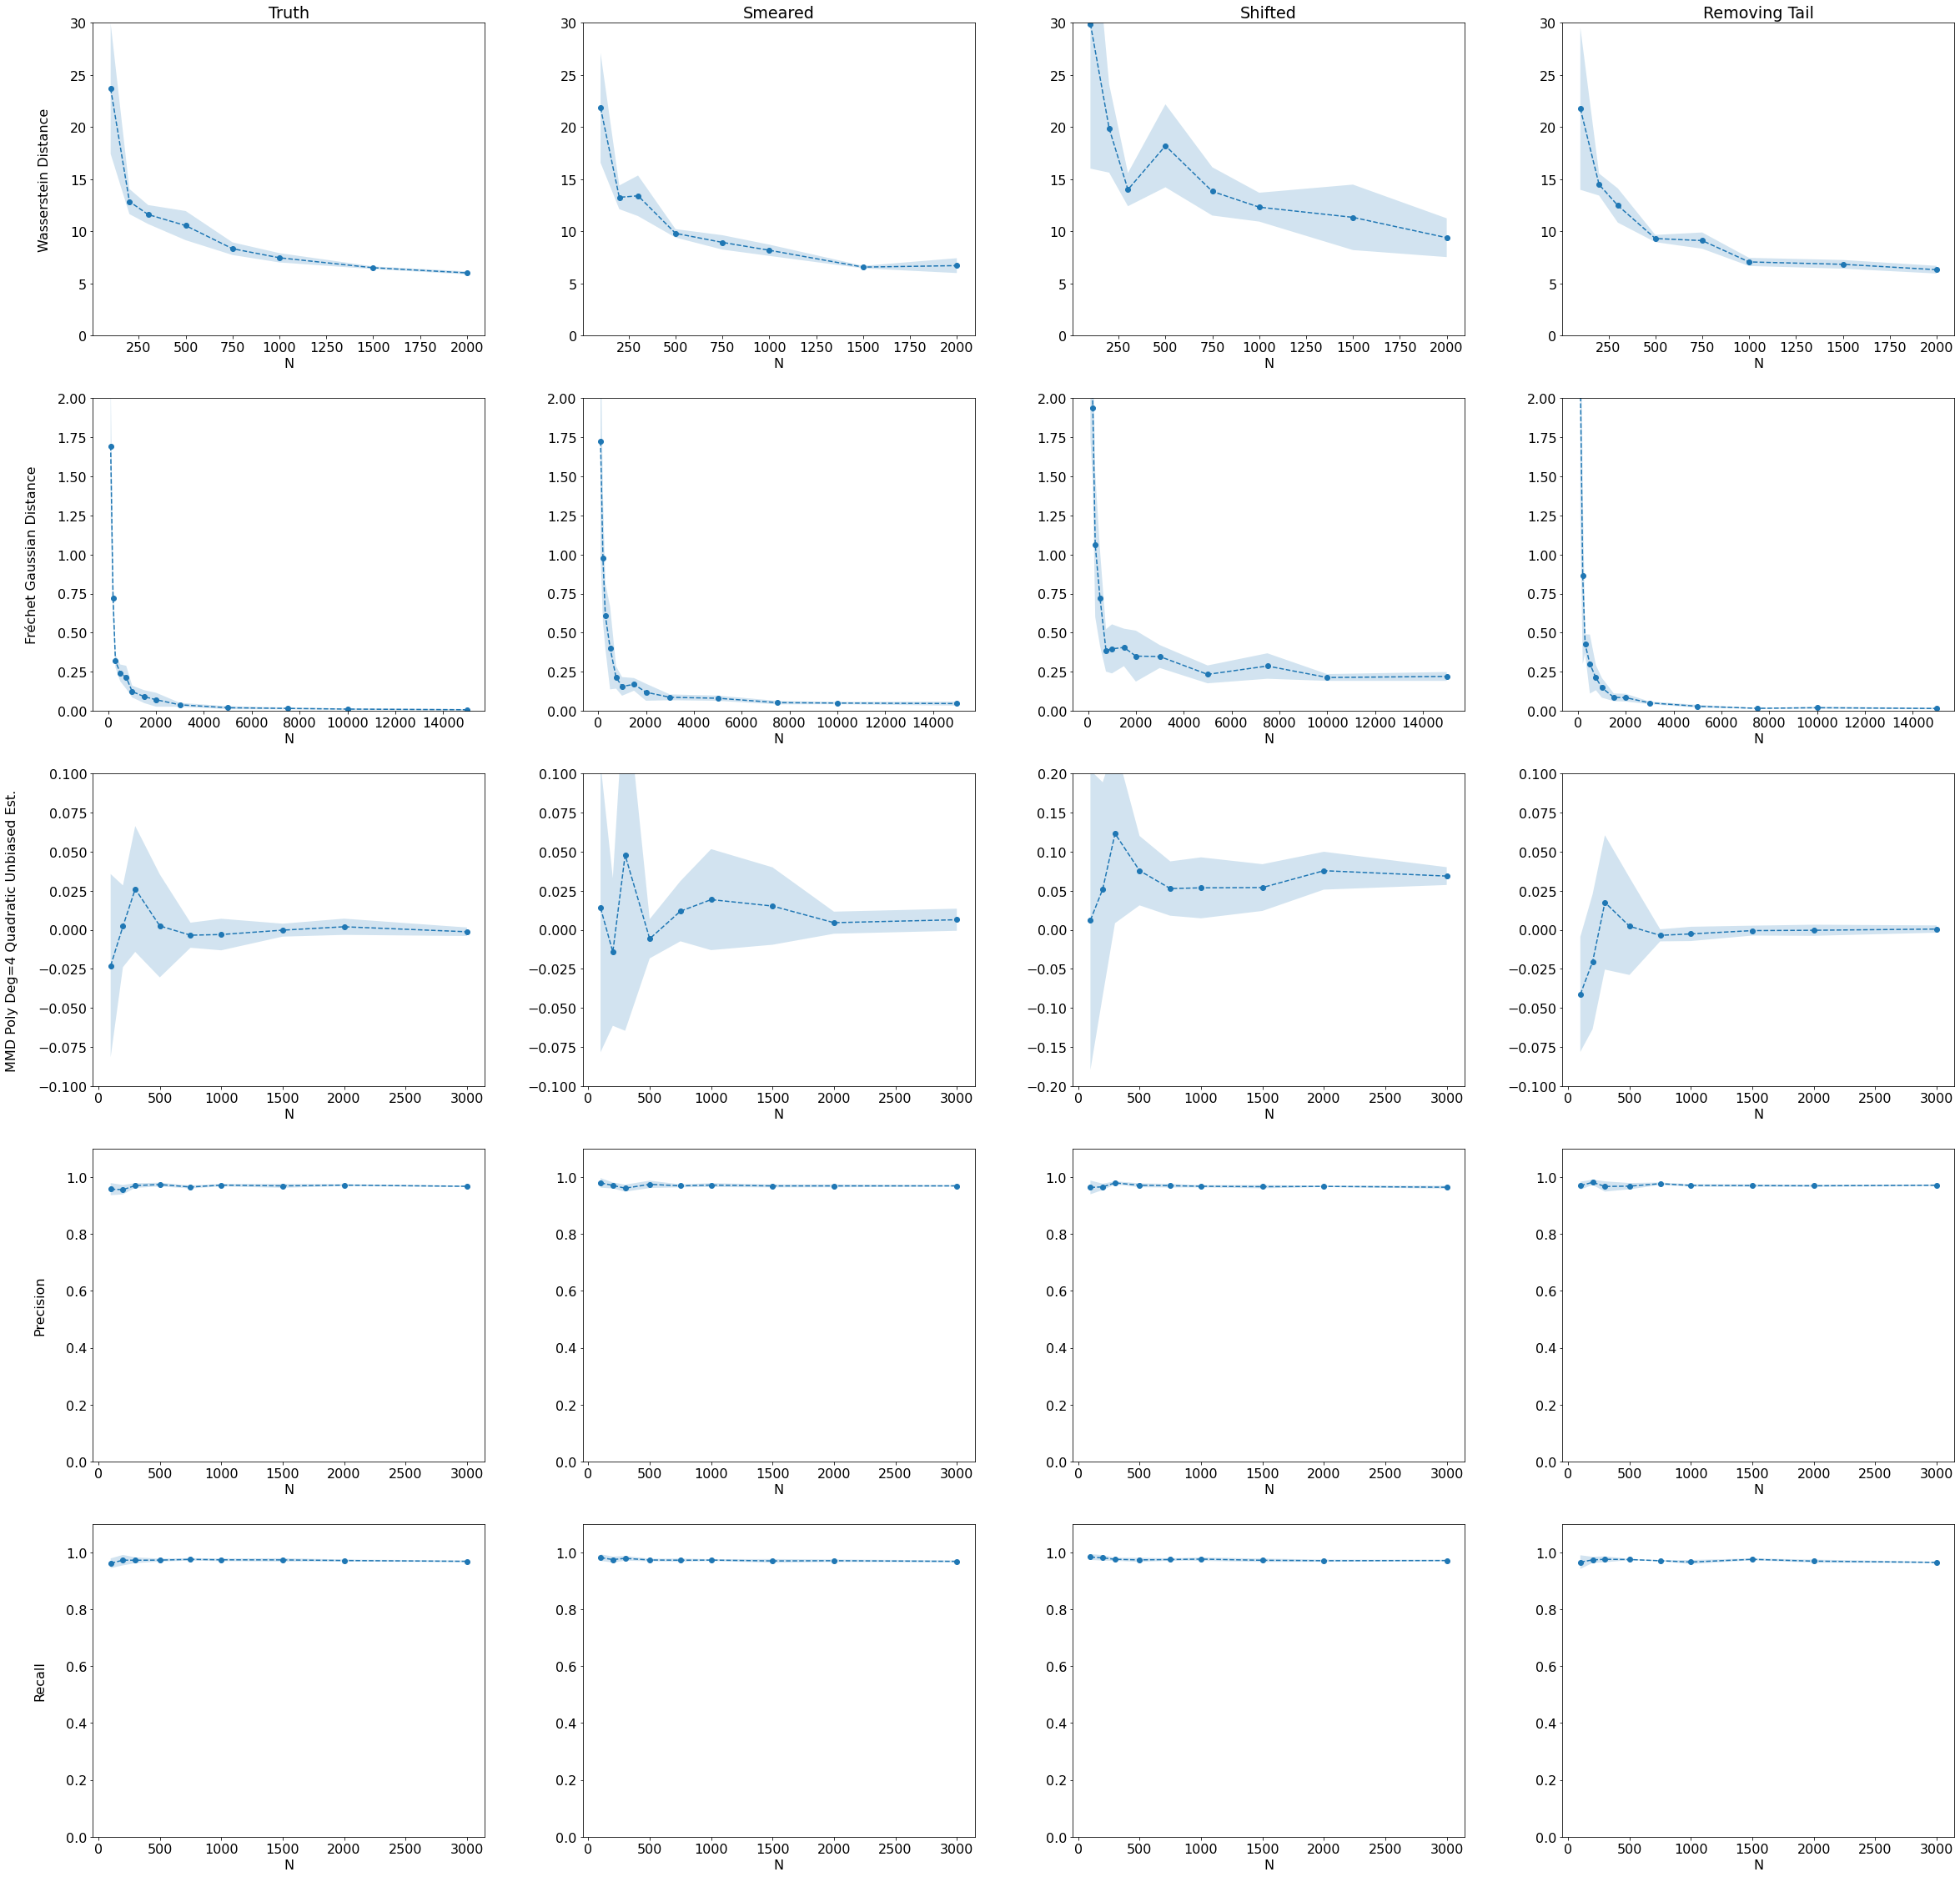

In [145]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 30], [0, 30], [0, 30], [0, 30])),
        ("fgd", ([0, 2], [0, 2], [0, 2], [0, 2])),
        ("mmdup4", ([-0.1, 0.1], [-0.1, 0.1], [-0.2, 0.2], [-0.1, 0.1])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists),
    figsize=(len(dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey == "prdc" or mkey == "dc" or mkey == "pr":
        continue

    axes[i][0].annotate(
        label,
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, (dkey, (_, label)) in enumerate(dists.items()):
        if i == 0:
            axes[i][j].set_title(label)

        means = np.nan_to_num(measurements_acts[dkey][mkey]["mean_std"][:, 0])[
            : len(batch_sizes[mkey])
        ]
        stds = np.nan_to_num(measurements_acts[dkey][mkey]["mean_std"][:, 1])[
            : len(batch_sizes[mkey])
        ]

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[mkey][j])
        axes[i][j].set_xlabel("N")

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, dkey in enumerate(dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(
            measurements_acts[dkey][mkey]["mean_std"][:, 0, k][: len(batch_sizes[mkey])]
        )
        stds = np.nan_to_num(
            measurements_acts[dkey][mkey]["mean_std"][:, 1, k][: len(batch_sizes[mkey])]
        )

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


plt.savefig(f"{plot_dir}/acts_scores.pdf", bbox_inches="tight")


In [147]:
rows = []

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        # for i, l in enumerate(label):
        #     row = [l + " EFP"]

        #     for dkey, values in measurements_efps.items():
        #         row.append(
        #             f"{values[mkey]['mean_std'][-1][0][i]:.3f} ± {values[mkey]['mean_std'][-1][1][i]:.3f}"
        #         )

        #     rows.append(row)
        continue
    else:
        row = [label + " EFP"]

        for dkey, values in measurements_efps.items():
            row.append(
                f"{values[mkey]['mean_std'][-1][0]:.3f} ± {values[mkey]['mean_std'][-1][1]:.3f}"
            )

        rows.append(row)

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        # for i, l in enumerate(label):
        #     row = [l + " PNet Activations"]

        #     for dkey, values in measurements_acts.items():
        #         row.append(
        #             f"{values[mkey]['mean_std'][-1][0][i]:.3f} ± {values[mkey]['mean_std'][-1][1][i]:.3f}"
        #         )

        #     rows.append(row)
        continue
    else:
        row = [label + " PNet Activations"]

        for dkey, values in measurements_acts.items():
            row.append(
                f"{values[mkey]['mean_std'][-1][0]:.3f} ± {values[mkey]['mean_std'][-1][1]:.3f}"
            )

        rows.append(row)

results = pd.DataFrame(
    rows, columns=["Metric"] + list(np.array(list(dists.values()), dtype=object)[:, 1])
)

display(Markdown(results.to_markdown()))


|    | Metric                                                  | Truth          | Smeared       | Shifted       | Removing Tail   |
|---:|:--------------------------------------------------------|:---------------|:--------------|:--------------|:----------------|
|  0 | Wasserstein Distance EFP                                | 0.012 ± 0.001  | 0.103 ± 0.030 | 0.093 ± 0.048 | 0.021 ± 0.009   |
|  1 | Fréchet Gaussian Distance EFP                           | 0.000 ± 0.000  | 0.025 ± 0.010 | 0.047 ± 0.014 | 0.004 ± 0.001   |
|  2 | MMD Poly Deg=4 Quadratic Unbiased Est. EFP              | -0.000 ± 0.000 | 0.003 ± 0.003 | 0.002 ± 0.001 | 0.000 ± 0.000   |
|  3 | Wasserstein Distance PNet Activations                   | 6.019 ± 0.142  | 6.713 ± 0.712 | 9.391 ± 1.860 | 6.323 ± 0.368   |
|  4 | Fréchet Gaussian Distance PNet Activations              | 0.005 ± 0.002  | 0.043 ± 0.008 | 0.211 ± 0.019 | 0.011 ± 0.003   |
|  5 | MMD Poly Deg=4 Quadratic Unbiased Est. PNet Activations | -0.001 ± 0.003 | 0.006 ± 0.007 | 0.069 ± 0.011 | 0.000 ± 0.002   |